In [2]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', None)
# import the required classes and definitions from Python-MIP
from mip import Model, xsum, maximize, BINARY, INTEGER

ModuleNotFoundError: No module named 'mip'

In [2]:
raw = pd.read_csv('top500histories', index_col=0)
top500_raw = pd.read_csv('top500.csv')

In [3]:
raw.columns

Index(['element', 'fixture', 'opponent_team', 'total_points', 'was_home',
       'kickoff_time', 'team_h_score', 'team_a_score', 'round', 'minutes',
       'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out', 'id_', 'web_name', 'gameweek', 'team',
       'sum_minutes', 'sum_points', 'next_week_points', 'team_a_conceded_rank',
       'team_a_conceded_rank_next', 'points_per_90'],
      dtype='object')

In [4]:
 df = top500_raw[['id_', 'web_name', 'team', 'element_type', 'assists', 'bonus', 'bps', 'clean_sheets', 
                 'goals_scored', 'minutes', 'saves', 'total_points',
                 'transfers_in', 'transfers_out']]

In [5]:
histories = raw[['id_', 'web_name', 'value', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'gameweek', 'saves', 'selected', 'total_points',
                 'team_a_score', 'team_h_score', 'transfers_in',
                 'transfers_out', 'sum_points', 'sum_minutes', 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'points_per_90', 'next_week_points']]

In [6]:
for gameweek in range(1, max(histories['gameweek'])): # + 1
    round_points = histories[histories['gameweek'] == gameweek][['id_', 'total_points']] 
    df = df.merge(round_points, on='id_', how='left', suffixes=('', '_' + str(gameweek)))
for gameweek in range(1, max(histories['gameweek'])): # + 1
    round_value = histories[histories['gameweek'] == gameweek][['id_', 'value']].rename(columns={'value':'value_' + str(gameweek)})
    df = df.merge(round_value, on='id_', how='left')
for gameweek in range(1, max(histories['gameweek'])): # + 1 
    round_minutes = histories[histories['gameweek'] == gameweek][['id_', 'minutes']].rename(columns={'minutes':'minutes_' + str(gameweek)})
    df = df.merge(round_minutes, on='id_', how='left')

In [7]:
df = df.fillna(0)

In [8]:
df

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,total_points_24,total_points_25,total_points_26,total_points_27,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,value_24,value_25,value_26,value_27,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27
0,215,De Bruyne,11,3,18,23,715,12,8,2148,0,178,5203682,3098553,7,11,5,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2.0,7.0,2.0,14.0,3.0,95,95,96,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107.0,107.0,107.0,108.0,108.0,78,90,90,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90.0,90.0,90.0,78.0,90.0
1,191,Salah,10,3,6,21,506,14,15,2153,0,177,3390648,3112670,12,3,15,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,3.0,3.0,10.0,6.0,7.0,2.0,14.0,16.0,3.0,7.0,125,125,125,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,122.0,123.0,123.0,123.0,123.0,124.0,124.0,126.0,127.0,128.0,90,78,90,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,69.0,90.0,90.0,90.0,90.0,84.0,90.0,90.0,90.0,90.0
2,182,Alexander-Arnold,10,2,14,18,709,11,2,2459,0,164,2742168,1269133,5,1,5,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,24.0,8.0,6.0,6.0,10.0,5.0,7.0,6.0,7.0,10.0,70,70,70,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,72.0,73.0,74.0,75.0,75.0,76.0,76.0,76.0,77.0,77.0,90,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90.0,90.0,90.0
3,192,Mané,10,3,8,19,481,9,13,1987,0,162,4018922,3463544,1,13,3,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,6.0,11.0,8.0,3.0,3.0,1.0,0.0,0.0,5.0,8.0,115,115,115,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,122.0,122.0,123.0,123.0,124.0,124.0,124.0,123.0,122.0,123.0,16,90,76,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,77.0,80.0,82.0,32.0,0.0,0.0,30.0,90.0
4,166,Vardy,9,4,6,25,565,8,17,2191,0,156,4494589,3182883,2,2,8,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0.0,1.0,2.0,2.0,2.0,90,90,89,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101.0,100.0,99.0,98.0,97.0,90,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90.0,42.0,79.0,90.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,41,Bong,4,2,0,0,15,0,0,57,0,3,2352,8230,0,0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,45,45,44.0,44.0,44.0,44.0,44.0,44.0,44.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,42.0,42.0,42.0,0,0,0,0.0,1.0,9.0,45.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [9]:
# position lists

keepers = list(df[df.element_type == 1].index)
defenders = list(df[df.element_type == 2].index)
midfielders = list(df[df.element_type == 3].index)
forwards = list(df[df.element_type == 4].index)

# team lists

ars = list(df[df.team == 1].index)
avl = list(df[df.team == 2].index)
bou = list(df[df.team == 3].index)
bha = list(df[df.team == 4].index)
bur = list(df[df.team == 5].index)
che = list(df[df.team == 6].index)
cry = list(df[df.team == 7].index)
eve = list(df[df.team == 8].index)
lei = list(df[df.team == 9].index)
liv = list(df[df.team == 10].index)
mci = list(df[df.team == 11].index)
mun = list(df[df.team == 12].index)
new = list(df[df.team == 13].index)
nor = list(df[df.team == 14].index)
shu = list(df[df.team == 15].index)
sou = list(df[df.team == 16].index)
tot = list(df[df.team == 17].index)
wat = list(df[df.team == 18].index)
whu = list(df[df.team == 19].index)
wol = list(df[df.team == 20].index)

In [10]:
# The selection models

def team_select(profit, weight, df):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = 830
    n = len(weight)

    #create an empty maximization
    m = Model('team_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 11.1
    m += xsum(df.element_type[i] * x[i] for i in keepers) >= 1 - .1
    m += xsum(df.element_type[i] * x[i] for i in keepers) <= 1 + .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) <= 10 + .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) <= 15 + .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) >= 4 - .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) <= 12 + .1

    # max 3 per team

    m += xsum(df.team[i] * x[i] for i in ars) <= 3
    m += xsum(df.team[i] * x[i] for i in avl) <= 6
    m += xsum(df.team[i] * x[i] for i in bou) <= 9
    m += xsum(df.team[i] * x[i] for i in bha) <= 12
    m += xsum(df.team[i] * x[i] for i in bur) <= 15
    m += xsum(df.team[i] * x[i] for i in che) <= 18
    m += xsum(df.team[i] * x[i] for i in cry) <= 21
    m += xsum(df.team[i] * x[i] for i in eve) <= 24
    m += xsum(df.team[i] * x[i] for i in lei) <= 27
    m += xsum(df.team[i] * x[i] for i in liv) <= 30
    m += xsum(df.team[i] * x[i] for i in mci) <= 33
    m += xsum(df.team[i] * x[i] for i in mun) <= 36
    m += xsum(df.team[i] * x[i] for i in new) <= 39
    m += xsum(df.team[i] * x[i] for i in nor) <= 42
    m += xsum(df.team[i] * x[i] for i in shu) <= 45
    m += xsum(df.team[i] * x[i] for i in sou) <= 48
    m += xsum(df.team[i] * x[i] for i in tot) <= 51
    m += xsum(df.team[i] * x[i] for i in wat) <= 54
    m += xsum(df.team[i] * x[i] for i in whu) <= 57
    m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    dream_team = df.iloc[selected,:].sort_values('element_type')
    return dream_team

In [11]:
def bench_select(profit, weight, formation, budget, data):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = budget
    n = len(weight)

    #create an empty maximization
    m = Model('bench_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 4.1
    m += xsum(data.element_type[i] * x[i] for i in keepers) >= .9
    m += xsum(data.element_type[i] * x[i] for i in keepers) <= 1.1
    m += xsum(data.element_type[i] * x[i] for i in defenders) >= 2 * formation[1] - .1
    m += xsum(data.element_type[i] * x[i] for i in defenders) <= 2 * formation[1] + .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) >= 3 * formation[2] - .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) <= 3 * formation[2] + .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) >= 4 * formation[3] - .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) <= 4 * formation[3] + .1

    # max 3 per team

#     m += xsum(df.team[i] * x[i] for i in ars) <= 3
#     m += xsum(df.team[i] * x[i] for i in avl) <= 6
#     m += xsum(df.team[i] * x[i] for i in bou) <= 9
#     m += xsum(df.team[i] * x[i] for i in bha) <= 12
#     m += xsum(df.team[i] * x[i] for i in bur) <= 15
#     m += xsum(df.team[i] * x[i] for i in che) <= 18
#     m += xsum(df.team[i] * x[i] for i in cry) <= 21
#     m += xsum(df.team[i] * x[i] for i in eve) <= 24
#     m += xsum(df.team[i] * x[i] for i in lei) <= 27
#     m += xsum(df.team[i] * x[i] for i in liv) <= 30
#     m += xsum(df.team[i] * x[i] for i in mci) <= 33
#     m += xsum(df.team[i] * x[i] for i in mun) <= 36
#     m += xsum(df.team[i] * x[i] for i in new) <= 39
#     m += xsum(df.team[i] * x[i] for i in nor) <= 42
#     m += xsum(df.team[i] * x[i] for i in shu) <= 45
#     m += xsum(df.team[i] * x[i] for i in sou) <= 48
#     m += xsum(df.team[i] * x[i] for i in tot) <= 51
#     m += xsum(df.team[i] * x[i] for i in wat) <= 54
#     m += xsum(df.team[i] * x[i] for i in whu) <= 57
#     m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    bench = data.iloc[selected,:].sort_values('element_type')
    return bench

In [12]:
mic = [91, 62, 52, 50, 74,
       71, 53, 50, 32, 77,
       85, 67, 86, 59, 50,
       71, 66, 43, 43, 58,
       61, 82, 42, 65, 54,
       0, 0, 0]

In [13]:
cooper = [83, 57, 57, 70, 58, 
          73, 52, 43, 32, 61, 
          74, 80, 58, 51, 55, 
          67, 65, 42, 28, 59, 
          54, 60, 45, 65, 60,
          0, 0, 0]

In [14]:
scout = [88, 65, 55, 64, 37, 
         90, 44, 36, 46, 51, 
         41, 87, 78, 56, 62, 
         65, 62, 28, 44, 53, 
         53, 58, 37, 77, 65,
         0, 0, 0]

In [15]:
global_ave = [65, 41, 44, 57, 52, 
              52, 51, 36, 37, 49,
              53, 48, 49, 51, 49,
              54, 56, 38, 49, 54,
              48, 57, 44, 53, 49,
              0, 0, 0]

In [16]:
top_10k_ave = [0.0, 0.0, 45.3, 54.5, 52.1,
             57.0, 50.8, 38.0, 35.9, 55.7,
             64.6, 65.5, 63.2, 50.3, 58.2,
             62.8, 61.6, 45.0, 53.0, 59.3,
             52.1, 60.1, 44.9, 62.9, 59.7,
              0, 0, 0]

In [17]:
team_points = pd.DataFrame({'scout':scout, 'mic':mic, 'cooper':cooper, 'top_10k':top_10k_ave, 'overall':global_ave})

In [18]:
team_points = team_points[:24]
team_points

,scout,mic,cooper,top_10k,overall
0,88,91,83,0.0,65
1,65,62,57,0.0,41
2,55,52,57,45.3,44
3,64,50,70,54.5,57
4,37,74,58,52.1,52
5,90,71,73,57.0,52
6,44,53,52,50.8,51
7,36,50,43,38.0,36
8,46,32,32,35.9,37
9,51,77,61,55.7,49


In [19]:
team_points['baseline'] = 0

In [20]:
team_points.head()

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0
1,65,62,57,0.0,41,0
2,55,52,57,45.3,44,0
3,64,50,70,54.5,57,0
4,37,74,58,52.1,52,0


In [21]:
number_of_alerts_baseline = 0
number_of_alerts_linear = 0
number_of_alerts_forest = 0

In [22]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,total_points_24,total_points_25,total_points_26,total_points_27,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,value_24,value_25,value_26,value_27,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27
0,215,De Bruyne,11,3,18,23,715,12,8,2148,0,178,5203682,3098553,7,11,5,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2.0,7.0,2.0,14.0,3.0,95,95,96,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107.0,107.0,107.0,108.0,108.0,78,90,90,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90.0,90.0,90.0,78.0,90.0
1,191,Salah,10,3,6,21,506,14,15,2153,0,177,3390648,3112670,12,3,15,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,3.0,3.0,10.0,6.0,7.0,2.0,14.0,16.0,3.0,7.0,125,125,125,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,122.0,123.0,123.0,123.0,123.0,124.0,124.0,126.0,127.0,128.0,90,78,90,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,69.0,90.0,90.0,90.0,90.0,84.0,90.0,90.0,90.0,90.0
2,182,Alexander-Arnold,10,2,14,18,709,11,2,2459,0,164,2742168,1269133,5,1,5,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,24.0,8.0,6.0,6.0,10.0,5.0,7.0,6.0,7.0,10.0,70,70,70,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,72.0,73.0,74.0,75.0,75.0,76.0,76.0,76.0,77.0,77.0,90,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90.0,90.0,90.0
3,192,Mané,10,3,8,19,481,9,13,1987,0,162,4018922,3463544,1,13,3,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,6.0,11.0,8.0,3.0,3.0,1.0,0.0,0.0,5.0,8.0,115,115,115,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,122.0,122.0,123.0,123.0,124.0,124.0,124.0,123.0,122.0,123.0,16,90,76,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,77.0,80.0,82.0,32.0,0.0,0.0,30.0,90.0
4,166,Vardy,9,4,6,25,565,8,17,2191,0,156,4494589,3182883,2,2,8,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0.0,1.0,2.0,2.0,2.0,90,90,89,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101.0,100.0,99.0,98.0,97.0,90,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90.0,42.0,79.0,90.0,90.0


In [23]:

for i in range(2, len(team_points.index) - 1):
    dream_team = team_select(df['total_points_'+ str(i)], df['value_'+ str(i)], df)
    next_week_points = dream_team['total_points_' + str(i + 1)]
    next_week_minutes = dream_team['minutes_' + str(i + 1)]
    print(dream_team[['total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
#     dream_team_cost = dream_team['value_' + str(i)].sum()
#     print('dream team cost: ', dream_team_cost)
#     bench_budget = 1000 - dream_team_cost
#     print('bench budget: ', bench_budget)
#     bench_pool = df
#     bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'total_points_' + str(i)] = 0
# #     print(bench_pool.head(40))


#     dream_team_formation = dream_team['element_type'].value_counts().sort_index()
#     print(dream_team_formation)
#     bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
#     print(bench_formation)
#     bench = bench_select(bench_pool['total_points_' + str(i)],
#                          bench_pool['value_' + str(i)],
#                          bench_formation,
#                          bench_budget,
#                          bench_pool)
    
#     print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    
#     bench_keeper = bench[bench['element_type'] == 1]
#     bench_field = bench[bench['element_type'] != 1].sort_values(['total_points_' + str(i)], ascending=False)
#     print(bench_field[['total_points_' + str(i), 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])
    
#     benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    

#     dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
#     dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
#     dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
#     for position in dream_team_played_formation.index:
#         dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
#     dream_team_played_formation = dream_team_played_formation_template
#     print(dream_team_played_formation)   

    
#     number_of_benched = benched.shape[0]
#     print('num of benched: ', number_of_benched)
    
#     bench_points = 0
    
#     if benched[benched['element_type'] == 1].shape[0] > 0:
#         bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
#         number_of_benched = number_of_benched - 1
    
    
    
#     if (dream_team_played_formation.loc[2] >= 3 and
#                     dream_team_played_formation.loc[2] <= 5 and
#                     dream_team_played_formation.loc[3] >= 2 and
#                     dream_team_played_formation.loc[3] <= 5 and
#                     dream_team_played_formation.loc[4] >= 1 and
#                     dream_team_played_formation.loc[4] <= 5):
#         bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
#     else:
#         print('ALERT! bench points not added')
#         number_of_alerts_baseline = number_of_alerts_baseline + 1
    
    

#     print('bench points: ', bench_points)

                
 
    
    captain = dream_team['total_points_' + str(i)].idxmax()
    final_points = sum(next_week_points)  + dream_team['total_points_' + str(i+1)][captain] # + bench_points
    team_points.baseline.loc[i] = final_points
    # adding the 'captain' points based on highest scoring player the previous week
   

     total_points_3   web_name  team  minutes_3
29                3   Patrício    20         90
20                0  Lundstram    15         90
38                1    Stevens    15         90
84                1      Digne     8         90
0                 5  De Bruyne    11         90
3                 3       Mané    10         76
158               2    Bernard     8         61
211               2     Lamela    17         61
279               2   Ceballos     1         60
13                2    Firmino    10         85
15               11      Pukki    14         90
     total_points_4     web_name  team  minutes_4
293             5.0         Gunn    16       90.0
88              6.0  van Aanholt     7       90.0
244            11.0  Vestergaard    16       90.0
275             6.0        Matip    10       90.0
1               6.0        Salah    10       90.0
66             10.0  David Silva    11       77.0
116             0.0      Redmond    16        0.0
281            10.0    F

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_5          web_name  team  minutes_5
352             2.0             Reina     2       90.0
2               2.0  Alexander-Arnold    10       90.0
244             5.0       Vestergaard    16       90.0
311             3.0           Masuaku    19       66.0
0               1.0         De Bruyne    11       33.0
12              4.0       Richarlison     8       80.0
54              2.0         Tielemans     9       90.0
272             1.0   Callum Robinson    15        6.0
4               2.0             Vardy     9       90.0
11             14.0           Abraham     6       76.0
16              6.0            Agüero    11       90.0
     total_points_6       web_name  team  minutes_6
170             8.0      Fabianski    19       90.0
80              1.0         Aurier    17       90.0
137             1.0   Alderweireld    17       90.0
205             0.0         Tomori     6       90.0
3               2.0           Mané    10       70.0
17              5.0         

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_7        web_name  team  minutes_7
52              4.0            Ryan     4       90.0
20              2.0       Lundstram    15       90.0
129             1.0        Otamendi    11       90.0
151             7.0       Cresswell    19       90.0
0               9.0       De Bruyne    11       79.0
21              0.0        Maddison     9        0.0
75              1.0  Bernardo Silva    11       10.0
142             8.0          McGinn     2       90.0
195             9.0      Yarmolenko    19       90.0
42              7.0            Wood     5       90.0
72              0.0            Jota    20        0.0
     total_points_8     web_name  team  minutes_8
339             2.0       Martin    19       90.0
19              1.0      Pereira     9       90.0
27              1.0      Doherty    20       22.0
40              0.0        Evans     9       90.0
18              1.0       Mahrez    11       59.0
44              8.0      Willian     6       90.0
82            

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_9    web_name  team  minutes_9
31              2.0      Foster    18       90.0
78              1.0        Dunk     4       90.0
107             2.0  David Luiz     1       90.0
132             2.0     Willems    13       90.0
3               2.0        Mané    10       90.0
35              2.0      Traoré    20       90.0
126             1.0    Hendrick     5       90.0
189             1.0   Hourihane     2       62.0
227             0.0      Milner    10        0.0
6               7.0     Jiménez    20       90.0
125             2.0      Wesley     2       75.0
     total_points_10     web_name  team  minutes_10
86               1.0     Pickford     8        90.0
67               2.0    O'Connell    15        90.0
110              6.0       Alonso     6        62.0
155              1.0      Targett     2        90.0
258              6.0      Janmaat    18        90.0
22               1.0     Grealish     2        83.0
59               9.0       Barnes     9        7

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

     total_points_11     web_name  team  minutes_11
68               2.0         Krul    14        90.0
57               6.0     Chilwell     9        90.0
92               6.0    Fernández    13        90.0
166              1.0    Lascelles    13        90.0
23               1.0     Sterling    11        90.0
28               3.0        Pérez     9        73.0
44               2.0      Willian     6        90.0
114              9.0      Pulisic     6        82.0
143              2.0  Milivojevic     7        90.0
4                6.0        Vardy     9        90.0
46               2.0       Maupay     4        90.0
     total_points_12    web_name  team  minutes_12
56               4.0    Ramsdale     3        90.0
20               2.0   Lundstram    15        90.0
50               8.0     Söyüncü     9        90.0
104              1.0      Walker    11        90.0
178             -1.0     Montoya     4        45.0
249              1.0  Adam Smith     3        77.0
3                7.

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_13        web_name  team  minutes_13
31               1.0          Foster    18        90.0
43              17.0       Tarkowski     5        90.0
198              1.0           Clark    13        90.0
205              1.0          Tomori     6        90.0
12               2.0     Richarlison     8        90.0
75               0.0  Bernardo Silva    11         0.0
81               1.0    Harry Wilson     3        45.0
121              2.0           Neves    20        90.0
239              2.0          Davies     8        90.0
4               12.0           Vardy     9        90.0
70               2.0        Deulofeu    18        90.0
     total_points_14    web_name  team  minutes_14
68               1.0        Krul    14        90.0
43               1.0   Tarkowski     5        90.0
202              0.0    Guilbert     2        90.0
213              1.0  Steve Cook     3        90.0
17              10.0         Son    17        87.0
62               1.0       Fleck  

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_15          web_name  team  minutes_15
36               8.0            Guaita     7        90.0
2                3.0  Alexander-Arnold    10        82.0
9                1.0          van Dijk    10        90.0
27               6.0           Doherty    20        90.0
151              0.0         Cresswell    19        90.0
17               2.0               Son    17        90.0
34               9.0              Alli    17        90.0
58               3.0              Zaha     7        90.0
81               2.0      Harry Wilson     3        90.0
5                2.0        Aubameyang     1        90.0
230              0.0         Iheanacho     9         0.0
     total_points_16    web_name  team  minutes_16
30               3.0    Dubravka    13        90.0
40               8.0       Evans     9        90.0
147              1.0        Rico     3        90.0
256              2.0   Manquillo    13        90.0
3                0.0        Mané    10         0.0
21        

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_17    web_name  team  minutes_17
36               8.0      Guaita     7        90.0
32               6.0     Baldock    15        90.0
193             10.0  Vertonghen    17        90.0
276              2.0    Williams    12        74.0
1               16.0       Salah    10        90.0
17               2.0         Son    17        90.0
76               2.0        Pépé     1        90.0
318              0.0       Keita    10         0.0
4                5.0       Vardy     9        90.0
39               1.0        Kane    17        90.0
72               2.0        Jota    20        90.0
     total_points_18    web_name  team  minutes_18
56               2.0    Ramsdale     3        90.0
20               6.0   Lundstram    15        90.0
193              1.0  Vertonghen    17        73.0
233              0.0     Pieters     5         0.0
0                4.0   De Bruyne    11        90.0
1                3.0       Salah    10        69.0
23               5.0    Sterlin

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_19          web_name  team  minutes_19
24               2.0         Henderson    15        90.0
2                8.0  Alexander-Arnold    10        90.0
110              0.0            Alonso     6         0.0
141              6.0          Stephens    16        90.0
168              2.0          Kabasele    18        90.0
44               2.0           Willian     6        83.0
47               2.0          Cantwell    14        90.0
95               1.0              Sarr    18        45.0
96               2.0           Almirón    13        62.0
7                1.0              Ings    16        21.0
13               2.0           Firmino    10        85.0
     total_points_20  web_name  team  minutes_20
157              2.0    Heaton     2        90.0
133              2.0    Sidibé     8        90.0
139              0.0   Webster     4         0.0
153              2.0  Bednarek    16        90.0
3                8.0      Mané    10        77.0
25               8.0  

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_21       web_name  team  minutes_21
31               2.0         Foster    18        90.0
8                6.0      Robertson    10        90.0
169              0.0     Fredericks    19         0.0
204              2.0        Tomkins     7        90.0
0                2.0      De Bruyne    11        90.0
1                6.0          Salah    10        90.0
28              13.0          Pérez     9        90.0
85               2.0          Noble    19        90.0
149              2.0           Mooy     4        67.0
33               1.0  Calvert-Lewin     8        90.0
122              1.0         Deeney    18        90.0
     total_points_22     web_name  team  minutes_22
69              13.0      Alisson    10        90.0
87              12.0  Azpilicueta     6        90.0
141              2.0     Stephens    16        90.0
185              2.0     Sokratis     1        90.0
21               2.0     Maddison     9        90.0
22               1.0     Grealish     2 

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
team_points

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0.0
1,65,62,57,0.0,41,0.0
2,55,52,57,45.3,44,43.0
3,64,50,70,54.5,57,97.0
4,37,74,58,52.1,52,44.0
5,90,71,73,57.0,52,38.0
6,44,53,52,50.8,51,49.0
7,36,50,43,38.0,36,22.0
8,46,32,32,35.9,37,24.0
9,51,77,61,55.7,49,52.0


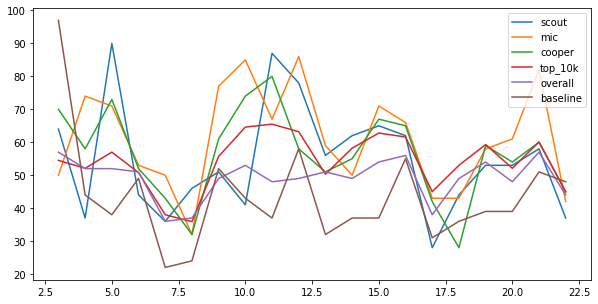

In [25]:
%matplotlib inline
team_points.loc[3:22].plot(figsize=(10,5))

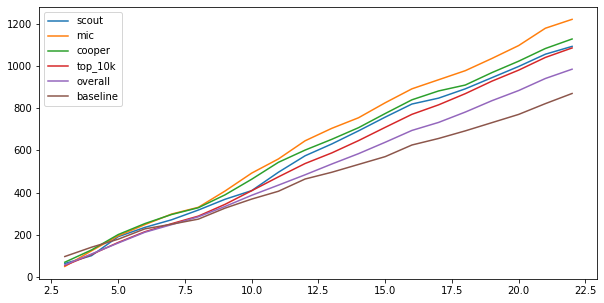

In [26]:
team_points.loc[3:22].cumsum().plot(figsize=(10,5))

In [27]:
team_points.loc[3:22].sum()

scout       1092.0
mic         1220.0
cooper      1127.0
top_10k     1084.6
overall      984.0
baseline     869.0
dtype: float64

In [28]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,total_points_24,total_points_25,total_points_26,total_points_27,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,value_24,value_25,value_26,value_27,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27
0,215,De Bruyne,11,3,18,23,715,12,8,2148,0,178,5203682,3098553,7,11,5,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2.0,7.0,2.0,14.0,3.0,95,95,96,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107.0,107.0,107.0,108.0,108.0,78,90,90,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90.0,90.0,90.0,78.0,90.0
1,191,Salah,10,3,6,21,506,14,15,2153,0,177,3390648,3112670,12,3,15,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,3.0,3.0,10.0,6.0,7.0,2.0,14.0,16.0,3.0,7.0,125,125,125,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,122.0,123.0,123.0,123.0,123.0,124.0,124.0,126.0,127.0,128.0,90,78,90,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,69.0,90.0,90.0,90.0,90.0,84.0,90.0,90.0,90.0,90.0
2,182,Alexander-Arnold,10,2,14,18,709,11,2,2459,0,164,2742168,1269133,5,1,5,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,24.0,8.0,6.0,6.0,10.0,5.0,7.0,6.0,7.0,10.0,70,70,70,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,72.0,73.0,74.0,75.0,75.0,76.0,76.0,76.0,77.0,77.0,90,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,77.0,90.0,90.0,90.0
3,192,Mané,10,3,8,19,481,9,13,1987,0,162,4018922,3463544,1,13,3,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,6.0,11.0,8.0,3.0,3.0,1.0,0.0,0.0,5.0,8.0,115,115,115,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,122.0,122.0,123.0,123.0,124.0,124.0,124.0,123.0,122.0,123.0,16,90,76,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,77.0,80.0,82.0,32.0,0.0,0.0,30.0,90.0
4,166,Vardy,9,4,6,25,565,8,17,2191,0,156,4494589,3182883,2,2,8,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0.0,1.0,2.0,2.0,2.0,90,90,89,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101.0,100.0,99.0,98.0,97.0,90,90,90,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90.0,42.0,79.0,90.0,90.0


In [29]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,gameweek,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [30]:
def linear_predict(gameweek, data):
    m = ols('next_week_points ~ goals_scored + assists + clean_sheets + saves + value + bps + selected + transfers_in + transfers_out + minutes + points_per_90',  data[data['gameweek'] <= gameweek - 1]).fit()
    next_week = data[data['gameweek'] == gameweek]
    predictions = m.predict(next_week)
    next_week['next_week_predictions'] = predictions   
    return next_week

In [31]:
team_points['linear_points'] = 0

In [32]:
for i in range(2, len(team_points.index) - 1):
    df_linear = linear_predict(i, histories)
    df_copy = df
    df_copy = df_copy.merge(df_linear[['id_', 'next_week_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.next_week_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    
    
#     dream_team_cost = dream_team['value_' + str(i)].sum()
#     print('dream team cost: ', dream_team_cost)
#     bench_budget = 1000 - dream_team_cost
#     print('bench budget: ', bench_budget)
#     bench_pool = df_copy
#     bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'next_week_predictions'] = 0


#     dream_team_formation = dream_team['element_type'].value_counts().sort_index()
#     bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
#     bench = bench_select(bench_pool['next_week_predictions'],
#                          bench_pool['value_' + str(i)],
#                          bench_formation,
#                          bench_budget,
#                          bench_pool)
    
#     print(bench.web_name)
#     print('bench cost: ', bench['value_' + str(i)].sum())
    
    
#     bench_keeper = bench[bench['element_type'] == 1]
#     bench_field = bench[bench['element_type'] != 1].sort_values(['next_week_predictions'], ascending=False)
#     print(bench_field[['next_week_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
#     benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
#     dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
#     dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
#     dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
#     for position in dream_team_played_formation.index:
#         dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
#     dream_team_played_formation = dream_team_played_formation_template
#     print(dream_team_played_formation)  
    
#     number_of_benched = benched.shape[0]
#     print('num of benched: ', number_of_benched)

#     bench_points = 0
    
#     if benched[benched['element_type'] == 1].shape[0] > 0:
#         bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
#         number_of_benched = number_of_benched - 1
    
    
    
#     if (dream_team_played_formation.loc[2] >= 3 and
#             dream_team_played_formation.loc[2] <= 5 and
#             dream_team_played_formation.loc[3] >= 2 and
#             dream_team_played_formation.loc[3] <= 5 and
#             dream_team_played_formation.loc[4] >= 1 and
#             dream_team_played_formation.loc[4] <= 5):
#         bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
#     else:
#         print('ALERT! bench points not added')
#         number_of_alerts_linear = number_of_alerts_linear + 1
    
    
#     print('bench points: ', bench_points)
    
    
    
    
    
    
    captain = dream_team['next_week_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] # + bench_points
    team_points['linear_points'].loc[i] = final_points

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

     total_points_3  web_name  minutes_3
448               0  Randolph          0
83                1    Basham         77
188               1      Burn         90
336               6    Krafth         90
394               2     Danso         72
273               1    Alzate         90
337               2  Bergwijn         77
388               3      Rupp         88
419               1  Bentaleb         90
423               1    Soucek         46
437               0    Niasse          0
     total_points_4     web_name  minutes_4
31              5.0       Foster       90.0
88              6.0  van Aanholt       90.0
129             6.0     Otamendi       90.0
275             6.0        Matip       90.0
1               6.0        Salah       90.0
23              3.0     Sterling       90.0
47              2.0     Cantwell       77.0
73              8.0        James       90.0
11             13.0      Abraham       83.0
16             16.0       Agüero       90.0
51              8.0     

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_5     web_name  minutes_5
352             2.0        Reina       90.0
93              6.0  Wan-Bissaka       90.0
182             1.0        Schär       79.0
244             5.0  Vestergaard       90.0
12              4.0  Richarlison       80.0
54              2.0    Tielemans       90.0
200             2.0      Eriksen       90.0
337             0.0     Bergwijn        0.0
4               2.0        Vardy       90.0
16              6.0       Agüero       90.0
39              5.0         Kane       84.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_6     web_name  minutes_6
48              2.0         Leno       90.0
93              1.0  Wan-Bissaka       90.0
132             6.0      Willems       81.0
205             0.0       Tomori       90.0
1               5.0        Salah       90.0
3               2.0         Mané       70.0
17              5.0          Son       90.0
47              2.0     Cantwell       89.0
5               5.0   Aubameyang       90.0
11              2.0      Abraham       76.0
15              2.0        Pukki       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


    total_points_7          web_name  minutes_7
48             3.0              Leno       90.0
2              6.0  Alexander-Arnold       90.0
9              8.0          van Dijk       90.0
84             1.0             Digne       90.0
0              9.0         De Bruyne       79.0
37             6.0             Mount       90.0
47             2.0          Cantwell       80.0
75             1.0    Bernardo Silva       10.0
5              9.0        Aubameyang       90.0
15             2.0             Pukki       90.0
39             8.0              Kane       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_8    web_name  minutes_8
52              7.0        Ryan       90.0
20              5.0   Lundstram       90.0
84              2.0       Digne       90.0
151             2.0   Cresswell       83.0
0               0.0   De Bruyne        0.0
23              2.0    Sterling       90.0
142             1.0      McGinn       90.0
195             1.0  Yarmolenko       77.0
5               2.0  Aubameyang       90.0
15              1.0       Pukki       83.0
39              2.0        Kane       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_9     web_name  minutes_9
26              3.0   Schmeichel       90.0
9               2.0     van Dijk       90.0
88              1.0  van Aanholt       90.0
135             0.0        Kelly        0.0
1               0.0        Salah        0.0
3               2.0         Mané       90.0
23              5.0     Sterling       90.0
37              3.0        Mount       63.0
197             0.0        Kanté        0.0
11              2.0      Abraham       90.0
125             2.0       Wesley       75.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_10          web_name  minutes_10
343              2.0           Roberto        90.0
2                1.0  Alexander-Arnold        90.0
9                2.0          van Dijk        90.0
139             -1.0           Webster        90.0
0                6.0         De Bruyne        75.0
3                5.0              Mané        90.0
34               2.0              Alli        90.0
54              11.0         Tielemans        90.0
4               20.0             Vardy        90.0
11               5.0           Abraham        69.0
15               2.0             Pukki        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_11   web_name  minutes_11
161              2.0  Gazzaniga        90.0
57               6.0   Chilwell        90.0
166              1.0  Lascelles        90.0
185              2.0   Sokratis        90.0
3               12.0       Mané        90.0
17               2.0        Son        78.0
37               1.0      Mount        90.0
114              9.0    Pulisic        82.0
4                6.0      Vardy        90.0
10               2.0   Rashford        90.0
39               0.0       Kane         0.0
     total_points_12          web_name  minutes_12
48               2.0              Leno        90.0
2                2.0  Alexander-Arnold        90.0
8                5.0         Robertson        90.0
20               2.0         Lundstram        90.0
104              1.0            Walker        90.0
0                2.0         De Bruyne        90.0
3                7.0              Mané        90.0
37               3.0             Mount        86.0
4            

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

     total_points_13   web_name  minutes_13
52               3.0       Ryan        90.0
8                6.0  Robertson        90.0
9                2.0   van Dijk        90.0
20               3.0  Lundstram        90.0
3                9.0       Mané        90.0
21               3.0   Maddison        90.0
25               2.0    Martial        84.0
114              2.0    Pulisic        90.0
4               12.0      Vardy        90.0
10              11.0   Rashford        90.0
11               2.0    Abraham        72.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


    total_points_14   web_name  minutes_14
52              2.0       Ryan        90.0
8               2.0  Robertson        90.0
20              2.0  Lundstram        90.0
43              1.0  Tarkowski        90.0
50              2.0    Söyüncü        90.0
0              10.0  De Bruyne        90.0
3               2.0       Mané        90.0
17             10.0        Son        87.0
21              2.0   Maddison        90.0
4               6.0      Vardy        90.0
6               5.0    Jiménez        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


    total_points_15          web_name  minutes_15
52              3.0              Ryan        90.0
2               3.0  Alexander-Arnold        82.0
9               1.0          van Dijk        90.0
20              1.0         Lundstram        90.0
78              2.0              Dunk        90.0
0               3.0         De Bruyne        79.0
17              2.0               Son        90.0
37              6.0             Mount        90.0
4               5.0             Vardy        90.0
5               2.0        Aubameyang        90.0
6               2.0           Jiménez        83.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


    total_points_16   web_name  minutes_16
48              3.0       Leno        90.0
9               6.0   van Dijk        90.0
20              2.0  Lundstram        90.0
50              2.0    Söyüncü        90.0
3               0.0       Mané         0.0
21              9.0   Maddison        90.0
34              9.0       Alli        84.0
37              2.0      Mount        90.0
4              13.0      Vardy        90.0
10              9.0   Rashford        90.0
11              2.0    Abraham        90.0
     total_points_17   web_name  minutes_17
90               6.0    Ederson        90.0
9                7.0   van Dijk        90.0
20              11.0  Lundstram        90.0
135              2.0      Kelly        90.0
17               2.0        Son        90.0
21               2.0   Maddison        90.0
22               0.0   Grealish        90.0
34               2.0       Alli        90.0
4                5.0      Vardy        90.0
11               2.0    Abraham        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

     total_points_18   web_name  minutes_18
36               2.0     Guaita        90.0
9                6.0   van Dijk        90.0
20               6.0  Lundstram        90.0
135              2.0      Kelly        90.0
0                4.0  De Bruyne        90.0
17              -1.0        Son        61.0
21               2.0   Maddison        90.0
58               2.0       Zaha        90.0
4                9.0      Vardy        90.0
10               2.0   Rashford        90.0
11               2.0    Abraham        79.0
     total_points_19          web_name  minutes_19
26               0.0        Schmeichel        90.0
2                8.0  Alexander-Arnold        90.0
9                6.0          van Dijk        90.0
20               2.0         Lundstram        90.0
135              2.0             Kelly        90.0
0                5.0         De Bruyne        66.0
3               11.0              Mané        90.0
22               6.0          Grealish        90.0
4            

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

     total_points_20          web_name  minutes_20
170              6.0         Fabianski        90.0
2                6.0  Alexander-Arnold        90.0
9                7.0          van Dijk        90.0
20               0.0         Lundstram         0.0
135              2.0             Kelly        90.0
0               14.0         De Bruyne        90.0
3                8.0              Mané        77.0
34               2.0              Alli        90.0
35               1.0            Traoré        32.0
4                0.0             Vardy         0.0
11               7.0           Abraham        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_21          web_name  minutes_21
30               3.0          Dubravka        90.0
2                6.0  Alexander-Arnold        90.0
9                6.0          van Dijk        90.0
135              2.0             Kelly        82.0
0                2.0         De Bruyne        90.0
3                3.0              Mané        80.0
22              13.0          Grealish        90.0
25               2.0           Martial        90.0
10               2.0          Rashford        90.0
11               5.0           Abraham        90.0
33               1.0     Calvert-Lewin        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


     total_points_22          web_name  minutes_22
171              3.0          McCarthy        90.0
2               10.0  Alexander-Arnold        90.0
9               15.0          van Dijk        90.0
20               6.0         Lundstram        69.0
0                9.0         De Bruyne        62.0
3                3.0              Mané        82.0
21               2.0          Maddison        90.0
22               1.0          Grealish        90.0
35               2.0            Traoré        90.0
10              12.0          Rashford        58.0
11               6.0           Abraham        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


    total_points_23          web_name  minutes_23
26              2.0        Schmeichel        90.0
2               5.0  Alexander-Arnold        90.0
9               2.0          van Dijk        90.0
20              2.0         Lundstram        66.0
0               2.0         De Bruyne        90.0
18              1.0            Mahrez        17.0
21              2.0          Maddison        90.0
47              3.0          Cantwell        90.0
4               0.0             Vardy        90.0
10              0.0          Rashford         0.0
11              2.0           Abraham        79.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


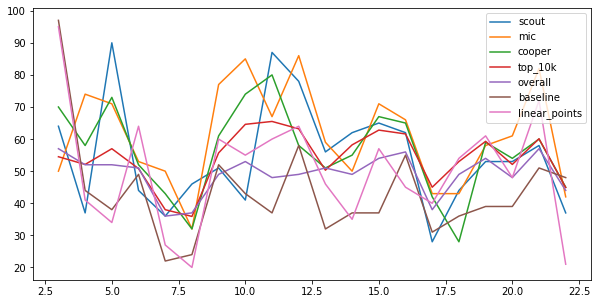

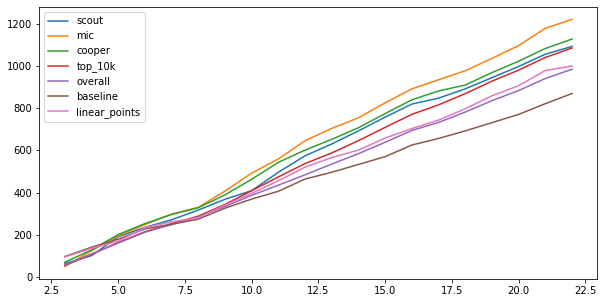

In [33]:
%matplotlib inline
team_points.loc[3:22].plot(figsize=(10,5))
team_points.loc[3:22].cumsum().plot(figsize=(10,5))

In [34]:
team_points.loc[3:22].sum()

scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          869.0
linear_points     999.0
dtype: float64

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
team_points.shape

(24, 7)

In [37]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,gameweek,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [38]:
df_forest = histories[['id_', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'gameweek', 'saves', 'selected', 
                 'total_points',
                 'transfers_in', 
                 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'transfers_out',
                 'points_per_90', 'next_week_points']].sort_values('gameweek')

In [39]:
df_forest.head()

,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,gameweek,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points
0,215,1,1,37,1,0,78,1,0,868463,7,0,20,13,0,8.076923,11
7556,453,0,0,2,0,0,90,1,0,55367,2,0,10,2,0,2.000000,1
7528,144,0,0,20,1,0,90,1,0,192717,6,0,1,13,0,6.000000,5
7500,135,0,0,14,1,0,90,1,0,212703,3,0,1,2,0,3.000000,2
804,411,0,0,23,1,0,90,1,1,271369,6,0,1,2,0,6.000000,9


In [40]:
def forest_predict(gameweek):
    df_clean = df_forest.drop('id_', axis=1)
    df_clean = df_clean[df_clean['gameweek'] <= gameweek - 1]
    X_train = df_clean.drop('next_week_points', axis=1)
    y_train = df_clean.next_week_points
    rfr = RandomForestRegressor(n_estimators=275, max_depth=4, random_state=42)
    rfr.fit(X_train, y_train)
    next_week = df_forest[df_forest['gameweek'] == gameweek]
    X_test = next_week.drop(['id_', 'next_week_points'], axis=1)
    y_pred = rfr.predict(X_test)
    next_week['forest_predictions'] = y_pred
    return next_week
    
    
    

In [41]:
team_points['forest_points'] = 0

In [42]:
for i in range(2, len(team_points.index) - 1):
    df_forest_predictions = forest_predict(i)
    df_copy = df
    df_copy = df_copy.merge(df_forest_predictions[['id_', 'forest_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.forest_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
#     dream_team_cost = dream_team['value_' + str(i)].sum()
#     print('dream team cost: ', dream_team_cost)
#     bench_budget = 1000 - dream_team_cost
#     print('bench budget: ', bench_budget)
#     bench_pool = df_copy
#     bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'forest_predictions'] = 0


#     dream_team_formation = dream_team['element_type'].value_counts().sort_index()
#     bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
#     bench = bench_select(bench_pool['forest_predictions'],
#                          bench_pool['value_' + str(i)],
#                          bench_formation,
#                          bench_budget,
#                          bench_pool)
    
#     print(bench.web_name)
#     print('bench cost: ', bench['value_' + str(i)].sum())
    
    
#     bench_keeper = bench[bench['element_type'] == 1]
#     bench_field = bench[bench['element_type'] != 1].sort_values(['forest_predictions'], ascending=False)
#     print(bench_field[['forest_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
#     benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
#     dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
#     dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
#     dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
#     for position in dream_team_played_formation.index:
#         dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
#     dream_team_played_formation = dream_team_played_formation_template
#     print(dream_team_played_formation)
    
#     number_of_benched = benched.shape[0]
#     print('num of benched: ', number_of_benched)

#     bench_points = 0
    
        
#     if benched[benched['element_type'] == 1].shape[0] > 0:
#         bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
#         number_of_benched = number_of_benched - 1
    
    
    
#     if (dream_team_played_formation.loc[2] >= 3 and
#                     dream_team_played_formation.loc[2] <= 5 and
#                     dream_team_played_formation.loc[3] >= 2 and
#                     dream_team_played_formation.loc[3] <= 5 and
#                     dream_team_played_formation.loc[4] >= 1 and
#                     dream_team_played_formation.loc[4] <= 5):
#         bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
#     else:
#         print('ALERT! bench points not added')
#         number_of_alerts_forest = number_of_alerts_forest + 1

    
#     print('bench points: ', bench_points)

    
    
    
    
    captain = dream_team['forest_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] # + bench_points
    team_points['forest_points'].loc[i] = final_points

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_3     web_name  minutes_3
55                1       de Gea         90
20                0    Lundstram         90
78                1         Dunk         90
84                1        Digne         90
98                2  Lucas Moura         90
121               2        Neves         90
211               2       Lamela         61
279               2     Ceballos         60
5                 5   Aubameyang         90
10                0     Rashford         90
395               0   Chicharito          0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_4       web_name  minutes_4
26              2.0     Schmeichel       90.0
8               6.0      Robertson       90.0
9               7.0       van Dijk       90.0
128             1.0            Aké       90.0
23              3.0       Sterling       90.0
47              2.0       Cantwell       77.0
281            10.0      Fernandes       90.0
347             0.0          Pedro        0.0
15              2.0          Pukki       90.0
16             16.0         Agüero       90.0
64              5.0  Callum Wilson       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_5          web_name  minutes_5
55              9.0            de Gea       90.0
2               2.0  Alexander-Arnold       90.0
8               5.0         Robertson       90.0
9               2.0          van Dijk       90.0
104             1.0            Walker       90.0
135             0.0             Kelly        0.0
0               1.0         De Bruyne       33.0
12              4.0       Richarlison       80.0
4               2.0             Vardy       90.0
11             14.0           Abraham       76.0
16              6.0            Agüero       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_6        web_name  minutes_6
55              2.0          de Gea       90.0
8               8.0       Robertson       90.0
79              1.0         Maguire       90.0
93              1.0     Wan-Bissaka       90.0
23              0.0        Sterling        0.0
37              2.0           Mount       90.0
47              2.0        Cantwell       89.0
75             19.0  Bernardo Silva       90.0
5               5.0      Aubameyang       90.0
11              2.0         Abraham       76.0
238             1.0        Connolly       45.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_7        web_name  minutes_7
29              9.0        Patrício       90.0
8               6.0       Robertson       90.0
9               8.0        van Dijk       90.0
104             2.0          Walker       90.0
0               9.0       De Bruyne       79.0
1               3.0           Salah       90.0
47              2.0        Cantwell       80.0
75              1.0  Bernardo Silva       10.0
10              4.0        Rashford       90.0
11              2.0         Abraham       83.0
15              2.0           Pukki       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_8    web_name  minutes_8
86              2.0    Pickford       90.0
9               2.0    van Dijk       90.0
79              2.0     Maguire       90.0
84              2.0       Digne       90.0
290             0.0   Zinchenko       45.0
0               0.0   De Bruyne        0.0
23              2.0    Sterling       90.0
37              7.0       Mount       79.0
5               2.0  Aubameyang       90.0
11              8.0     Abraham       83.0
117             2.0        King       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_9      web_name  minutes_9
56              6.0      Ramsdale       90.0
84              6.0         Digne       90.0
193             2.0    Vertonghen       90.0
213             9.0    Steve Cook       90.0
17              1.0           Son       45.0
35              2.0        Traoré       90.0
47              3.0      Cantwell       80.0
81              3.0  Harry Wilson       68.0
11              2.0       Abraham       90.0
16              0.0        Agüero        0.0
39              2.0          Kane       90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


    total_points_10        web_name  minutes_10
55              2.0          de Gea        90.0
40              6.0           Evans        90.0
84             -1.0           Digne        90.0
93              1.0     Wan-Bissaka        90.0
0               6.0       De Bruyne        75.0
47              1.0        Cantwell        45.0
66              9.0     David Silva        90.0
73              6.0           James        79.0
75              3.0  Bernardo Silva        90.0
15              2.0           Pukki        90.0
39              7.0            Kane        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_11     web_name  minutes_11
52               6.0         Ryan        90.0
57               6.0     Chilwell        90.0
78               7.0         Dunk        90.0
139              1.0      Webster        35.0
0                2.0    De Bruyne        90.0
1                2.0        Salah        64.0
23               1.0     Sterling        90.0
37               1.0        Mount        90.0
66               1.0  David Silva        45.0
11              12.0      Abraham        87.0
15               2.0        Pukki        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

     total_points_12        web_name  minutes_12
86               2.0        Pickford        90.0
20               2.0       Lundstram        90.0
57               6.0        Chilwell        90.0
84               2.0           Digne        90.0
0                2.0       De Bruyne        90.0
12              10.0     Richarlison        88.0
75              10.0  Bernardo Silva        90.0
124              2.0      Dendoncker        90.0
4               12.0           Vardy        90.0
15               2.0           Pukki        90.0
16               2.0          Agüero        70.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_13     web_name  minutes_13
86               2.0     Pickford        90.0
20               3.0    Lundstram        90.0
84               1.0        Digne        90.0
107              1.0   David Luiz        90.0
0                7.0    De Bruyne        90.0
12               2.0  Richarlison        90.0
17              13.0          Son        90.0
221              1.0    Guendouzi        90.0
5                5.0   Aubameyang        90.0
15               5.0        Pukki        90.0
39               6.0         Kane        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_14   web_name  minutes_14
31               2.0     Foster        90.0
8                2.0  Robertson        90.0
19               7.0    Pereira        90.0
57               2.0   Chilwell        90.0
0               10.0  De Bruyne        90.0
3                2.0       Mané        90.0
47               8.0   Cantwell        82.0
114              2.0    Pulisic        90.0
4                6.0      Vardy        90.0
11               0.0    Abraham         0.0
70               2.0   Deulofeu        66.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_15          web_name  minutes_15
26              6.0        Schmeichel        90.0
2               3.0  Alexander-Arnold        82.0
8               1.0         Robertson        90.0
9               1.0          van Dijk        90.0
0               3.0         De Bruyne        79.0
21             10.0          Maddison        90.0
37              6.0             Mount        90.0
47              2.0          Cantwell        82.0
4               5.0             Vardy        90.0
5               2.0        Aubameyang        90.0
15              8.0             Pukki        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_16          web_name  minutes_16
26               2.0        Schmeichel        90.0
2                1.0  Alexander-Arnold        50.0
20               2.0         Lundstram        90.0
135              8.0             Kelly        90.0
3                0.0              Mané         0.0
17              12.0               Son        90.0
21               9.0          Maddison        90.0
37               2.0             Mount        90.0
58               2.0              Zaha        90.0
4               13.0             Vardy        90.0
11               2.0           Abraham        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

     total_points_17   web_name  minutes_17
24               6.0  Henderson        90.0
9                7.0   van Dijk        90.0
20              11.0  Lundstram        90.0
50               3.0    Söyüncü        90.0
135              2.0      Kelly        90.0
1               16.0      Salah        90.0
3                6.0       Mané        90.0
21               2.0   Maddison        90.0
4                5.0      Vardy        90.0
10               2.0   Rashford        90.0
109              2.0    Mousset        60.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_18     web_name  minutes_18
29               4.0     Patrício        90.0
20               6.0    Lundstram        90.0
93               1.0  Wan-Bissaka        90.0
135              2.0        Kelly        90.0
0                4.0    De Bruyne        90.0
35               2.0       Traoré        90.0
37               3.0        Mount        90.0
73               1.0        James        57.0
6                7.0      Jiménez        90.0
10               2.0     Rashford        90.0
11               2.0      Abraham        79.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_19   web_name  minutes_19
24               2.0  Henderson        90.0
9                6.0   van Dijk        90.0
20               2.0  Lundstram        90.0
135              2.0      Kelly        90.0
3               11.0       Mané        90.0
22               6.0   Grealish        90.0
37               1.0      Mount        45.0
47               2.0   Cantwell        90.0
4                2.0      Vardy        90.0
11               2.0    Abraham        90.0
15               1.0      Pukki        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_20          web_name  minutes_20
36               3.0            Guaita        90.0
2                6.0  Alexander-Arnold        90.0
20               0.0         Lundstram         0.0
135              2.0             Kelly        90.0
0               14.0         De Bruyne        90.0
21               1.0          Maddison        26.0
34               2.0              Alli        90.0
47               1.0          Cantwell         4.0
4                0.0             Vardy         0.0
11               7.0           Abraham        90.0
39               8.0              Kane        90.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_21          web_name  minutes_21
36               3.0            Guaita        90.0
2                6.0  Alexander-Arnold        90.0
8                6.0         Robertson        90.0
9                6.0          van Dijk        90.0
20               1.0         Lundstram        90.0
135              2.0             Kelly        82.0
0                2.0         De Bruyne        90.0
21              11.0          Maddison        76.0
4                0.0             Vardy         0.0
11               5.0           Abraham        90.0
39               2.0              Kane        74.0


/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


     total_points_22    web_name  minutes_22
26               4.0  Schmeichel        90.0
8                6.0   Robertson        90.0
9               15.0    van Dijk        90.0
135              2.0       Kelly        90.0
0                9.0   De Bruyne        62.0
1                7.0       Salah        90.0
21               2.0    Maddison        90.0
47               2.0    Cantwell        90.0
6                2.0     Jiménez        90.0
10              12.0    Rashford        58.0
11               6.0     Abraham        90.0
     total_points_23   web_name  minutes_23
52               2.0       Ryan        90.0
8                1.0  Robertson        90.0
9                2.0   van Dijk        90.0
20               2.0  Lundstram        66.0
135              1.0      Kelly        90.0
0                2.0  De Bruyne        90.0
1                2.0      Salah        84.0
21               2.0   Maddison        90.0
4                0.0      Vardy        90.0
7                2.0

/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/cooper/.virtualenvs/fpl/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
team_points

,scout,mic,cooper,top_10k,overall,baseline,linear_points,forest_points
0,88,91,83,0.0,65,0.0,0.0,0.0
1,65,62,57,0.0,41,0.0,0.0,0.0
2,55,52,57,45.3,44,43.0,20.0,16.0
3,64,50,70,54.5,57,97.0,95.0,57.0
4,37,74,58,52.1,52,44.0,41.0,50.0
5,90,71,73,57.0,52,38.0,34.0,48.0
6,44,53,52,50.8,51,49.0,64.0,50.0
7,36,50,43,38.0,36,22.0,27.0,37.0
8,46,32,32,35.9,37,24.0,20.0,38.0
9,51,77,61,55.7,49,52.0,60.0,48.0


scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          869.0
linear_points     999.0
forest_points     969.0
dtype: float64

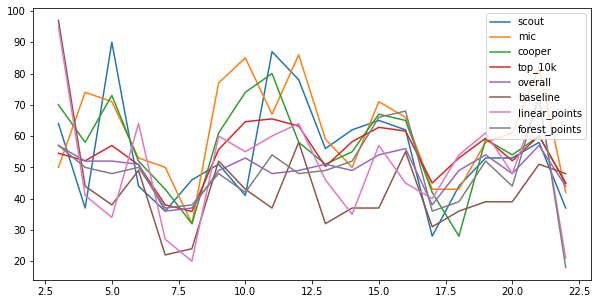

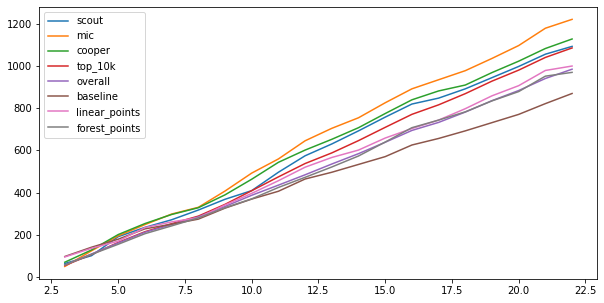

In [44]:
team_points.loc[3:22].plot(figsize=(10,5))
team_points.loc[3:22].cumsum().plot(figsize=(10,5))
team_points.loc[3:22].sum()

In [45]:
print('number of times missing bench points baseline:', number_of_alerts_baseline)
print('number of times missing bench points linear:', number_of_alerts_forest)
print('number of times missing bench points forest:', number_of_alerts_forest)

number of times missing bench points baseline: 0
number of times missing bench points linear: 0
number of times missing bench points forest: 0


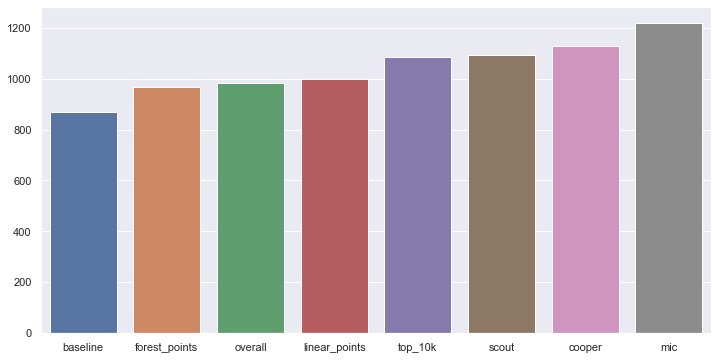

In [46]:
sums = team_points.loc[3:22].sum().sort_values()
sns.set(rc={'figure.figsize':(12, 6)})
sns.barplot(x = sums.index, y = sums)